In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['fast_bowl', 'spin_bowl']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)


Total training images: 1710
Total validation images: 432
Total test images: 549
Total images in dataset: 2691


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))


Training images (excluding 'random_occlusion'): 1520
Validation images (excluding 'random_occlusion'): 384
Test images (excluding 'random_occlusion'): 488
Total images (excluding 'random_occlusion'): 2392


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'low_resolution', 'lens_flare', 'blur', 'gaussian_noise', 'random_occlusion', 'dirty_lens', 'motion_blur', 'original', 'chromatic_aberration'}
Validation folders considered: {'low_resolution', 'lens_flare', 'blur', 'gaussian_noise', 'random_occlusion', 'dirty_lens', 'motion_blur', 'original', 'chromatic_aberration'}
Test folders considered: {'low_resolution', 'lens_flare', 'blur', 'gaussian_noise', 'random_occlusion', 'dirty_lens', 'motion_blur', 'original', 'chromatic_aberration'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))


Classes: ['fast_bowl', 'spin_bowl']
Final Training images: 1520
Final Validation images: 384
Final Test images: 488
Total images after filtering: 2392


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'low_resolution', 'lens_flare', 'blur', 'gaussian_noise', 'dirty_lens', 'motion_blur', 'original', 'chromatic_aberration'}
Validation folders considered: {'low_resolution', 'lens_flare', 'blur', 'gaussian_noise', 'dirty_lens', 'motion_blur', 'original', 'chromatic_aberration'}
Test folders considered: {'low_resolution', 'lens_flare', 'blur', 'gaussian_noise', 'dirty_lens', 'motion_blur', 'original', 'chromatic_aberration'}


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import os
import tempfile

# -----------------------------
# 1. Data Preprocessing with Filtering (ViT - 224x224)
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

# ViT-B/16 uses 224x224 input size
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT-B/16 input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    """Filter out samples containing the ignore_folder in their path"""
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]
    return dataset

# Create and filter datasets
print("üîÑ Loading and filtering datasets for Vision Transformer...")
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Apply filtering
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Display information
classes = train_ds.classes
print(f"‚úÖ Classes: {classes}")
print(f"üìä Dataset Statistics:")
print(f"‚îÇ Training images: {len(train_ds)}")
print(f"‚îÇ Validation images: {len(val_ds)}")
print(f"‚îÇ Test images: {len(test_ds)}")
print(f"‚îÇ Total images (after filtering): {len(train_ds) + len(val_ds) + len(test_ds)}")
print(f"‚îÇ Excluded folder: '{ignore_folder}'")
print(f"‚îÇ Number of classes: {len(classes)}")

üîÑ Loading and filtering datasets for Vision Transformer...
‚úÖ Classes: ['fast_bowl', 'spin_bowl']
üìä Dataset Statistics:
‚îÇ Training images: 1520
‚îÇ Validation images: 384
‚îÇ Test images: 488
‚îÇ Total images (after filtering): 2392
‚îÇ Excluded folder: 'random_occlusion'
‚îÇ Number of classes: 2


In [8]:
# -----------------------------
# 2. Pretrained Vision Transformer Model
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained Vision Transformer (ViT-B/16)
print("üîÑ Loading pretrained Vision Transformer (ViT-B/16) from ImageNet...")
model = models.vit_b_16(pretrained=True)

# Replace final classification layer
# ViT uses model.heads.head (nested structure)
num_features = model.heads.head.in_features  # Get input features (768)
model.heads.head = nn.Linear(num_features, len(classes))  # Replace final layer
model = model.to(device)

print(f"‚úÖ Model loaded with {len(classes)} output classes")

# Calculate model parameters and size
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calculate model file size
with tempfile.NamedTemporaryFile(delete=False, suffix='.pth') as tmp_file:
    torch.save(model.state_dict(), tmp_file.name)
    model_size_mb = os.path.getsize(tmp_file.name) / (1024 * 1024)
    os.unlink(tmp_file.name)

print(f"üìä Total parameters: {total_params:,}")
print(f"üìä Trainable parameters: {trainable_params:,}")
print(f"üìä Model file size: {model_size_mb:.2f} MB")
print(f"üìã Model Architecture:")
print(f"‚îÇ Input size: (3, 224, 224)")
print(f"‚îÇ ViT-B/16 features: 768")
print(f"‚îÇ Output classes: {len(classes)}")
print(f"‚îÇ Patch size: 16x16")
print(f"‚îÇ Sequence length: 196 patches + 1 CLS token")
print(f"‚îÇ Transformer layers: 12")
print(f"‚îÇ Attention heads: 12")

Using device: cuda
üîÑ Loading pretrained Vision Transformer (ViT-B/16) from ImageNet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 330M/330M [00:01<00:00, 207MB/s]


‚úÖ Model loaded with 2 output classes
üìä Total parameters: 85,800,194
üìä Trainable parameters: 85,800,194
üìä Model file size: 327.36 MB
üìã Model Architecture:
‚îÇ Input size: (3, 224, 224)
‚îÇ ViT-B/16 features: 768
‚îÇ Output classes: 2
‚îÇ Patch size: 16x16
‚îÇ Sequence length: 196 patches + 1 CLS token
‚îÇ Transformer layers: 12
‚îÇ Attention heads: 12



üìã Training Configuration:
‚îÇ Model: Vision Transformer ViT-B/16 (pretrained)
‚îÇ Optimizer: Adam (lr=0.0001)
‚îÇ Loss Function: CrossEntropyLoss
‚îÇ Batch Size: 32
‚îÇ Device: cuda
‚îÇ Data: Filtered (excluding 'random_occlusion')

üöÄ Starting Vision Transformer Fine-tuning for 50 epochs...

üìà Epoch 1/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:09<00:00,  1.46s/it, Loss=0.3180, Acc=0.8461]


‚úÖ Training completed in 69.85s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:08<00:00,  1.36it/s, Loss=0.8282, Acc=0.7057]


‚úÖ Validation completed in 8.80s
üåü New best model found! Validation Loss: 0.8282

üìä Epoch 1 Summary:
‚îÇ Train Loss: 0.3180 | Train Acc: 0.8461
‚îÇ Val Loss:   0.8282 | Val Acc:   0.7057
‚îÇ Train Time: 69.85s | Val Time: 8.80s
‚îÇ Total Epoch Time: 78.65s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 2/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:01<00:00,  1.28s/it, Loss=0.0638, Acc=0.9770]


‚úÖ Training completed in 61.61s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.85it/s, Loss=0.9490, Acc=0.6953]


‚úÖ Validation completed in 6.48s

üìä Epoch 2 Summary:
‚îÇ Train Loss: 0.0638 | Train Acc: 0.9770
‚îÇ Val Loss:   0.9490 | Val Acc:   0.6953
‚îÇ Train Time: 61.61s | Val Time: 6.48s
‚îÇ Total Epoch Time: 68.09s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 3/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:03<00:00,  1.33s/it, Loss=0.0051, Acc=0.9993]


‚úÖ Training completed in 63.65s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.87it/s, Loss=1.3122, Acc=0.6719]


‚úÖ Validation completed in 6.40s

üìä Epoch 3 Summary:
‚îÇ Train Loss: 0.0051 | Train Acc: 0.9993
‚îÇ Val Loss:   1.3122 | Val Acc:   0.6719
‚îÇ Train Time: 63.65s | Val Time: 6.40s
‚îÇ Total Epoch Time: 70.06s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 4/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:05<00:00,  1.36s/it, Loss=0.0004, Acc=1.0000]


‚úÖ Training completed in 65.43s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.88it/s, Loss=1.3532, Acc=0.7135]


‚úÖ Validation completed in 6.40s

üìä Epoch 4 Summary:
‚îÇ Train Loss: 0.0004 | Train Acc: 1.0000
‚îÇ Val Loss:   1.3532 | Val Acc:   0.7135
‚îÇ Train Time: 65.43s | Val Time: 6.40s
‚îÇ Total Epoch Time: 71.83s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 5/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.39s/it, Loss=0.0002, Acc=1.0000]


‚úÖ Training completed in 66.53s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.85it/s, Loss=1.4059, Acc=0.7161]


‚úÖ Validation completed in 6.51s

üìä Epoch 5 Summary:
‚îÇ Train Loss: 0.0002 | Train Acc: 1.0000
‚îÇ Val Loss:   1.4059 | Val Acc:   0.7161
‚îÇ Train Time: 66.53s | Val Time: 6.51s
‚îÇ Total Epoch Time: 73.04s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 6/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.39s/it, Loss=0.0001, Acc=1.0000]


‚úÖ Training completed in 66.79s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.80it/s, Loss=1.4492, Acc=0.7214]


‚úÖ Validation completed in 6.65s

üìä Epoch 6 Summary:
‚îÇ Train Loss: 0.0001 | Train Acc: 1.0000
‚îÇ Val Loss:   1.4492 | Val Acc:   0.7214
‚îÇ Train Time: 66.79s | Val Time: 6.65s
‚îÇ Total Epoch Time: 73.45s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 7/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:07<00:00,  1.41s/it, Loss=0.0001, Acc=1.0000]


‚úÖ Training completed in 67.50s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.83it/s, Loss=1.4848, Acc=0.7214]


‚úÖ Validation completed in 6.57s

üìä Epoch 7 Summary:
‚îÇ Train Loss: 0.0001 | Train Acc: 1.0000
‚îÇ Val Loss:   1.4848 | Val Acc:   0.7214
‚îÇ Train Time: 67.50s | Val Time: 6.57s
‚îÇ Total Epoch Time: 74.08s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 8/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:07<00:00,  1.40s/it, Loss=0.0001, Acc=1.0000]


‚úÖ Training completed in 67.19s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.82it/s, Loss=1.5195, Acc=0.7214]


‚úÖ Validation completed in 6.60s

üìä Epoch 8 Summary:
‚îÇ Train Loss: 0.0001 | Train Acc: 1.0000
‚îÇ Val Loss:   1.5195 | Val Acc:   0.7214
‚îÇ Train Time: 67.19s | Val Time: 6.60s
‚îÇ Total Epoch Time: 73.79s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 9/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:07<00:00,  1.41s/it, Loss=0.0001, Acc=1.0000]


‚úÖ Training completed in 67.65s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.72it/s, Loss=1.5505, Acc=0.7214]


‚úÖ Validation completed in 6.99s

üìä Epoch 9 Summary:
‚îÇ Train Loss: 0.0001 | Train Acc: 1.0000
‚îÇ Val Loss:   1.5505 | Val Acc:   0.7214
‚îÇ Train Time: 67.65s | Val Time: 6.99s
‚îÇ Total Epoch Time: 74.64s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 10/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:12<00:00,  1.51s/it, Loss=0.0001, Acc=1.0000]


‚úÖ Training completed in 72.50s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.74it/s, Loss=1.5794, Acc=0.7188]


‚úÖ Validation completed in 6.92s

üìä Epoch 10 Summary:
‚îÇ Train Loss: 0.0001 | Train Acc: 1.0000
‚îÇ Val Loss:   1.5794 | Val Acc:   0.7188
‚îÇ Train Time: 72.50s | Val Time: 6.92s
‚îÇ Total Epoch Time: 79.42s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 11/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:12<00:00,  1.50s/it, Loss=0.0001, Acc=1.0000]


‚úÖ Training completed in 72.17s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.73it/s, Loss=1.6072, Acc=0.7214]


‚úÖ Validation completed in 6.94s

üìä Epoch 11 Summary:
‚îÇ Train Loss: 0.0001 | Train Acc: 1.0000
‚îÇ Val Loss:   1.6072 | Val Acc:   0.7214
‚îÇ Train Time: 72.17s | Val Time: 6.94s
‚îÇ Total Epoch Time: 79.11s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 12/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:12<00:00,  1.50s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 72.08s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.73it/s, Loss=1.6323, Acc=0.7188]


‚úÖ Validation completed in 6.94s

üìä Epoch 12 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.6323 | Val Acc:   0.7188
‚îÇ Train Time: 72.08s | Val Time: 6.94s
‚îÇ Total Epoch Time: 79.02s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 13/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:11<00:00,  1.50s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 71.78s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.78it/s, Loss=1.6558, Acc=0.7188]


‚úÖ Validation completed in 6.76s

üìä Epoch 13 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.6558 | Val Acc:   0.7188
‚îÇ Train Time: 71.78s | Val Time: 6.76s
‚îÇ Total Epoch Time: 78.55s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 14/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:11<00:00,  1.50s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 71.80s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.77it/s, Loss=1.6783, Acc=0.7188]


‚úÖ Validation completed in 6.80s

üìä Epoch 14 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.6783 | Val Acc:   0.7188
‚îÇ Train Time: 71.80s | Val Time: 6.80s
‚îÇ Total Epoch Time: 78.60s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 15/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:11<00:00,  1.49s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 71.67s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.75it/s, Loss=1.7003, Acc=0.7188]


‚úÖ Validation completed in 6.85s

üìä Epoch 15 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.7003 | Val Acc:   0.7188
‚îÇ Train Time: 71.67s | Val Time: 6.85s
‚îÇ Total Epoch Time: 78.53s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 16/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:11<00:00,  1.49s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 71.66s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.73it/s, Loss=1.7209, Acc=0.7188]


‚úÖ Validation completed in 6.94s

üìä Epoch 16 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.7209 | Val Acc:   0.7188
‚îÇ Train Time: 71.66s | Val Time: 6.94s
‚îÇ Total Epoch Time: 78.60s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 17/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:08<00:00,  1.43s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 68.69s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.81it/s, Loss=1.7410, Acc=0.7161]


‚úÖ Validation completed in 6.65s

üìä Epoch 17 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.7410 | Val Acc:   0.7161
‚îÇ Train Time: 68.69s | Val Time: 6.65s
‚îÇ Total Epoch Time: 75.34s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 18/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:07<00:00,  1.40s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 67.38s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.83it/s, Loss=1.7599, Acc=0.7188]


‚úÖ Validation completed in 6.56s

üìä Epoch 18 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.7599 | Val Acc:   0.7188
‚îÇ Train Time: 67.38s | Val Time: 6.56s
‚îÇ Total Epoch Time: 73.95s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 19/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.39s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.81s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.85it/s, Loss=1.7782, Acc=0.7188]


‚úÖ Validation completed in 6.50s

üìä Epoch 19 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.7782 | Val Acc:   0.7188
‚îÇ Train Time: 66.81s | Val Time: 6.50s
‚îÇ Total Epoch Time: 73.31s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 20/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.39s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.51s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.85it/s, Loss=1.7966, Acc=0.7161]


‚úÖ Validation completed in 6.49s

üìä Epoch 20 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.7966 | Val Acc:   0.7161
‚îÇ Train Time: 66.51s | Val Time: 6.49s
‚îÇ Total Epoch Time: 73.01s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 21/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.38s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.38s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.82it/s, Loss=1.8131, Acc=0.7161]


‚úÖ Validation completed in 6.59s

üìä Epoch 21 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.8131 | Val Acc:   0.7161
‚îÇ Train Time: 66.38s | Val Time: 6.59s
‚îÇ Total Epoch Time: 72.97s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 22/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.38s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.27s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.83it/s, Loss=1.8298, Acc=0.7161]


‚úÖ Validation completed in 6.54s

üìä Epoch 22 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.8298 | Val Acc:   0.7161
‚îÇ Train Time: 66.27s | Val Time: 6.54s
‚îÇ Total Epoch Time: 72.82s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 23/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.38s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.28s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.86it/s, Loss=1.8461, Acc=0.7135]


‚úÖ Validation completed in 6.46s

üìä Epoch 23 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.8461 | Val Acc:   0.7135
‚îÇ Train Time: 66.28s | Val Time: 6.46s
‚îÇ Total Epoch Time: 72.75s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 24/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.38s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.18s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.83it/s, Loss=1.8615, Acc=0.7135]


‚úÖ Validation completed in 6.56s

üìä Epoch 24 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.8615 | Val Acc:   0.7135
‚îÇ Train Time: 66.18s | Val Time: 6.56s
‚îÇ Total Epoch Time: 72.74s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 25/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.38s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.39s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.87it/s, Loss=1.8770, Acc=0.7135]


‚úÖ Validation completed in 6.41s

üìä Epoch 25 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.8770 | Val Acc:   0.7135
‚îÇ Train Time: 66.39s | Val Time: 6.41s
‚îÇ Total Epoch Time: 72.80s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 26/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.38s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.05s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.79it/s, Loss=1.8915, Acc=0.7135]


‚úÖ Validation completed in 6.71s

üìä Epoch 26 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.8915 | Val Acc:   0.7135
‚îÇ Train Time: 66.05s | Val Time: 6.71s
‚îÇ Total Epoch Time: 72.77s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 27/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:05<00:00,  1.37s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.00s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.88it/s, Loss=1.9060, Acc=0.7135]


‚úÖ Validation completed in 6.38s

üìä Epoch 27 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.9060 | Val Acc:   0.7135
‚îÇ Train Time: 66.00s | Val Time: 6.38s
‚îÇ Total Epoch Time: 72.39s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 28/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:11<00:00,  1.49s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 71.48s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.76it/s, Loss=1.9201, Acc=0.7135]


‚úÖ Validation completed in 6.83s

üìä Epoch 28 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.9201 | Val Acc:   0.7135
‚îÇ Train Time: 71.48s | Val Time: 6.83s
‚îÇ Total Epoch Time: 78.31s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 29/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:11<00:00,  1.49s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 71.60s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.74it/s, Loss=1.9338, Acc=0.7135]


‚úÖ Validation completed in 6.89s

üìä Epoch 29 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.9338 | Val Acc:   0.7135
‚îÇ Train Time: 71.60s | Val Time: 6.89s
‚îÇ Total Epoch Time: 78.49s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 30/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:11<00:00,  1.49s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 71.52s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.73it/s, Loss=1.9469, Acc=0.7135]


‚úÖ Validation completed in 6.92s

üìä Epoch 30 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.9469 | Val Acc:   0.7135
‚îÇ Train Time: 71.52s | Val Time: 6.92s
‚îÇ Total Epoch Time: 78.44s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 31/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:11<00:00,  1.50s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 71.93s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.74it/s, Loss=1.9603, Acc=0.7135]


‚úÖ Validation completed in 6.91s

üìä Epoch 31 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.9603 | Val Acc:   0.7135
‚îÇ Train Time: 71.93s | Val Time: 6.91s
‚îÇ Total Epoch Time: 78.84s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 32/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:11<00:00,  1.48s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 71.10s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.76it/s, Loss=1.9732, Acc=0.7161]


‚úÖ Validation completed in 6.84s

üìä Epoch 32 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.9732 | Val Acc:   0.7161
‚îÇ Train Time: 71.10s | Val Time: 6.84s
‚îÇ Total Epoch Time: 77.95s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 33/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:11<00:00,  1.50s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 71.90s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.73it/s, Loss=1.9858, Acc=0.7161]


‚úÖ Validation completed in 6.93s

üìä Epoch 33 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.9858 | Val Acc:   0.7161
‚îÇ Train Time: 71.90s | Val Time: 6.93s
‚îÇ Total Epoch Time: 78.83s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 34/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:12<00:00,  1.50s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 72.08s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.72it/s, Loss=1.9982, Acc=0.7161]


‚úÖ Validation completed in 6.97s

üìä Epoch 34 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   1.9982 | Val Acc:   0.7161
‚îÇ Train Time: 72.08s | Val Time: 6.97s
‚îÇ Total Epoch Time: 79.05s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 35/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:11<00:00,  1.49s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 71.63s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.75it/s, Loss=2.0102, Acc=0.7161]


‚úÖ Validation completed in 6.85s

üìä Epoch 35 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.0102 | Val Acc:   0.7161
‚îÇ Train Time: 71.63s | Val Time: 6.85s
‚îÇ Total Epoch Time: 78.49s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 36/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:08<00:00,  1.44s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 68.90s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.80it/s, Loss=2.0218, Acc=0.7161]


‚úÖ Validation completed in 6.66s

üìä Epoch 36 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.0218 | Val Acc:   0.7161
‚îÇ Train Time: 68.90s | Val Time: 6.66s
‚îÇ Total Epoch Time: 75.57s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 37/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:07<00:00,  1.41s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 67.88s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.84it/s, Loss=2.0341, Acc=0.7161]


‚úÖ Validation completed in 6.52s

üìä Epoch 37 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.0341 | Val Acc:   0.7161
‚îÇ Train Time: 67.88s | Val Time: 6.52s
‚îÇ Total Epoch Time: 74.40s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 38/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.39s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.71s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.85it/s, Loss=2.0455, Acc=0.7161]


‚úÖ Validation completed in 6.50s

üìä Epoch 38 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.0455 | Val Acc:   0.7161
‚îÇ Train Time: 66.71s | Val Time: 6.50s
‚îÇ Total Epoch Time: 73.22s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 39/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.39s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.85s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.82it/s, Loss=2.0570, Acc=0.7161]


‚úÖ Validation completed in 6.61s

üìä Epoch 39 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.0570 | Val Acc:   0.7161
‚îÇ Train Time: 66.85s | Val Time: 6.61s
‚îÇ Total Epoch Time: 73.47s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 40/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.38s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.41s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.86it/s, Loss=2.0679, Acc=0.7161]


‚úÖ Validation completed in 6.44s

üìä Epoch 40 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.0679 | Val Acc:   0.7161
‚îÇ Train Time: 66.41s | Val Time: 6.44s
‚îÇ Total Epoch Time: 72.85s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 41/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.39s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.60s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.86it/s, Loss=2.0791, Acc=0.7161]


‚úÖ Validation completed in 6.46s

üìä Epoch 41 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.0791 | Val Acc:   0.7161
‚îÇ Train Time: 66.60s | Val Time: 6.46s
‚îÇ Total Epoch Time: 73.07s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 42/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.39s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.50s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.84it/s, Loss=2.0900, Acc=0.7188]


‚úÖ Validation completed in 6.52s

üìä Epoch 42 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.0900 | Val Acc:   0.7188
‚îÇ Train Time: 66.50s | Val Time: 6.52s
‚îÇ Total Epoch Time: 73.03s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 43/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.38s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.32s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.85it/s, Loss=2.1007, Acc=0.7188]


‚úÖ Validation completed in 6.48s

üìä Epoch 43 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.1007 | Val Acc:   0.7188
‚îÇ Train Time: 66.32s | Val Time: 6.48s
‚îÇ Total Epoch Time: 72.81s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 44/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.38s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.38s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.84it/s, Loss=2.1110, Acc=0.7188]


‚úÖ Validation completed in 6.51s

üìä Epoch 44 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.1110 | Val Acc:   0.7188
‚îÇ Train Time: 66.38s | Val Time: 6.51s
‚îÇ Total Epoch Time: 72.89s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 45/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.38s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.44s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.86it/s, Loss=2.1216, Acc=0.7188]


‚úÖ Validation completed in 6.47s

üìä Epoch 45 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.1216 | Val Acc:   0.7188
‚îÇ Train Time: 66.44s | Val Time: 6.47s
‚îÇ Total Epoch Time: 72.91s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 46/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:06<00:00,  1.38s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 66.17s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.86it/s, Loss=2.1320, Acc=0.7188]


‚úÖ Validation completed in 6.44s

üìä Epoch 46 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.1320 | Val Acc:   0.7188
‚îÇ Train Time: 66.17s | Val Time: 6.44s
‚îÇ Total Epoch Time: 72.61s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 47/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:11<00:00,  1.49s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 71.29s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.74it/s, Loss=2.1423, Acc=0.7188]


‚úÖ Validation completed in 6.91s

üìä Epoch 47 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.1423 | Val Acc:   0.7188
‚îÇ Train Time: 71.29s | Val Time: 6.91s
‚îÇ Total Epoch Time: 78.20s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 48/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:13<00:00,  1.52s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 73.04s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:07<00:00,  1.68it/s, Loss=2.1521, Acc=0.7161]


‚úÖ Validation completed in 7.14s

üìä Epoch 48 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.1521 | Val Acc:   0.7161
‚îÇ Train Time: 73.04s | Val Time: 7.14s
‚îÇ Total Epoch Time: 80.18s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 49/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:12<00:00,  1.50s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 72.10s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.72it/s, Loss=2.1621, Acc=0.7161]


‚úÖ Validation completed in 6.96s

üìä Epoch 49 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.1621 | Val Acc:   0.7161
‚îÇ Train Time: 72.10s | Val Time: 6.96s
‚îÇ Total Epoch Time: 79.07s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üìà Epoch 50/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [01:11<00:00,  1.49s/it, Loss=0.0000, Acc=1.0000]


‚úÖ Training completed in 71.64s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.74it/s, Loss=2.1718, Acc=0.7161]


‚úÖ Validation completed in 6.90s

üìä Epoch 50 Summary:
‚îÇ Train Loss: 0.0000 | Train Acc: 1.0000
‚îÇ Val Loss:   2.1718 | Val Acc:   0.7161
‚îÇ Train Time: 71.64s | Val Time: 6.90s
‚îÇ Total Epoch Time: 78.55s
‚îÇ Best Val Loss: 0.8282 (Epoch 1)
‚îÇ GPU Memory: 1.3GB / 5.0GB

üíæ Best model saved as 'best_cricket_vit_filtered.pth'
üìä Best model stats:
‚îÇ Best Epoch: 1
‚îÇ Best Val Loss: 0.8282
‚îÇ Best Val Acc: 0.7057

üíæ Training history saved to 'cricket_vit_filtered_history_pretrained.csv'

üéâ Vision Transformer Fine-tuning Complete!
Total Training Time: 3765.55s (62.8 minutes)
Average Epoch Time: 75.31s

üß™ Loading Best Model for Testing...
‚úÖ Best model from epoch 1 loaded successfully!


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:12<00:00,  1.29it/s]


‚úÖ Testing completed in 12.45s

üìã Classification Report:
              precision    recall  f1-score   support

   fast_bowl       0.78      0.75      0.77       304
   spin_bowl       0.61      0.65      0.63       184

    accuracy                           0.71       488
   macro avg       0.70      0.70      0.70       488
weighted avg       0.72      0.71      0.71       488

üéØ Test Accuracy: 0.7131

üìä Cricket Classification Performance (Vision Transformer - Filtered Data):
‚îÇ Best Validation Loss: 0.8282 (Epoch 1)
‚îÇ Best Validation Acc:  0.7057 (Epoch 1)
‚îÇ Final Test Accuracy:  0.7131
‚îÇ Val-Test Gap:         0.0074
‚îÇ Data Filtering: Excluded 'random_occlusion' folder

üíæ Files saved:
‚îÇ best_cricket_vit_filtered.pth - Best model weights
‚îÇ cricket_vit_filtered_history.csv - Training metrics


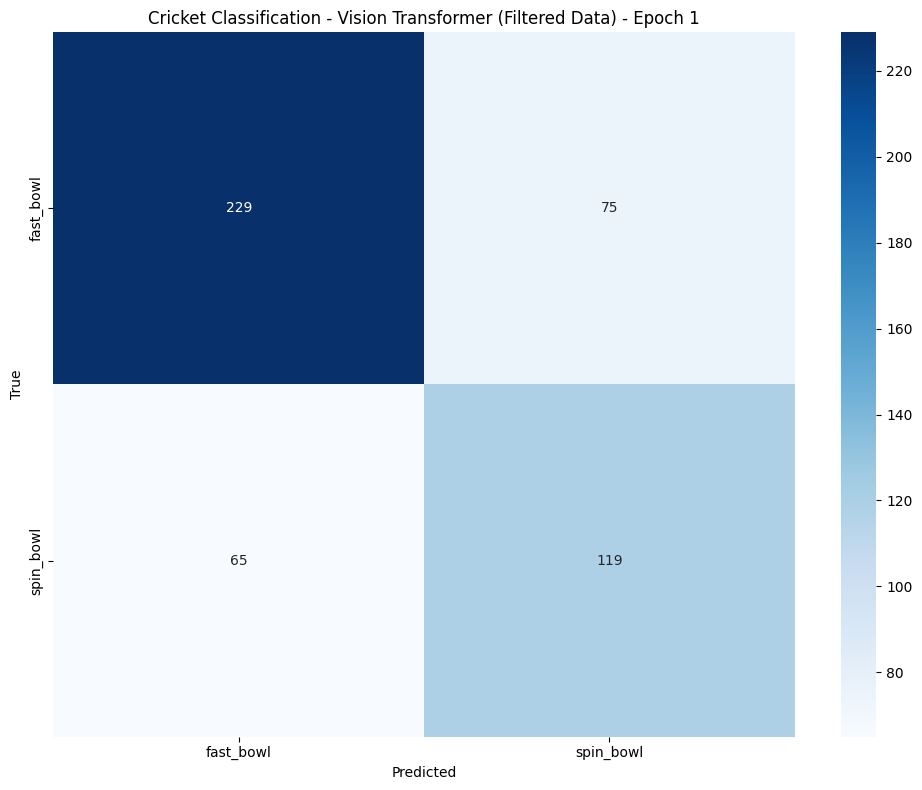

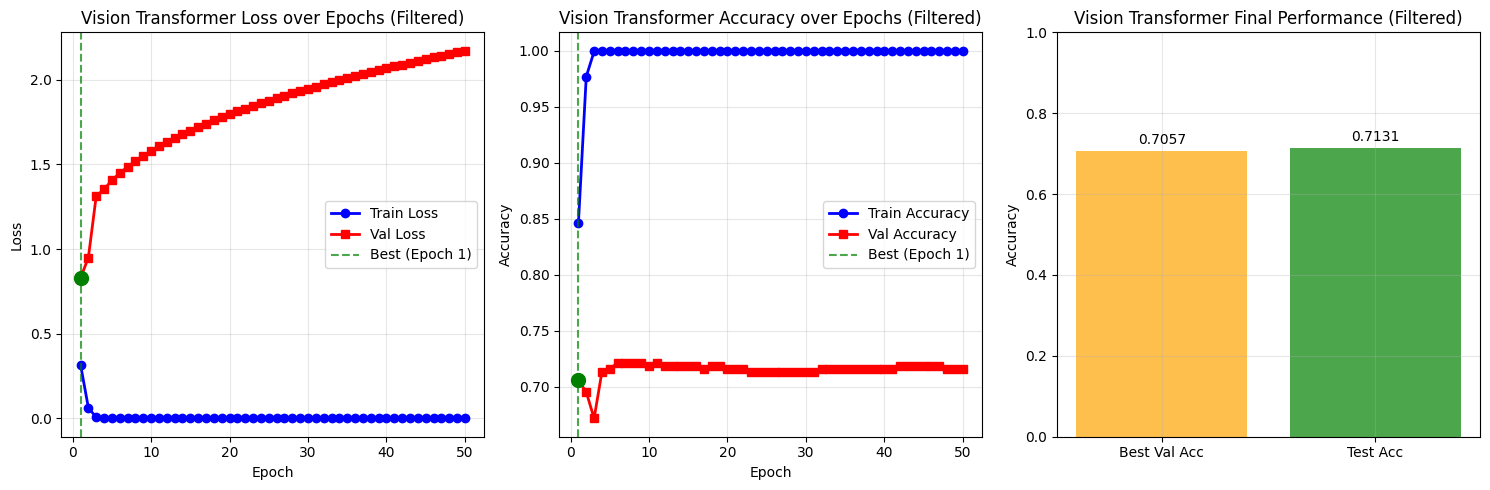


‚è∞ Final Timing Summary:
‚îÇ Total Training: 3765.55s (62.8 min)
‚îÇ Average per Epoch: 75.31s
‚îÇ Testing Time: 12.45s
‚îÇ Total Runtime: 3777.99s

üîç Vision Transformer + Filtered Data Benefits:
‚îÇ Clean dataset: 'random_occlusion' folder excluded
‚îÇ Self-attention: Global context understanding
‚îÇ Patch-based: 16x16 patches processed as sequences
‚îÇ Transformer architecture: State-of-the-art NLP applied to vision
‚îÇ ImageNet-21k pretrained: High-quality feature representations
‚îÇ Long-range dependencies: Better than CNNs for complex relationships


In [9]:
# -----------------------------
# 3. Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for fine-tuning

print(f"\nüìã Training Configuration:")
print(f"‚îÇ Model: Vision Transformer ViT-B/16 (pretrained)")
print(f"‚îÇ Optimizer: Adam (lr={optimizer.param_groups[0]['lr']})")
print(f"‚îÇ Loss Function: CrossEntropyLoss")
print(f"‚îÇ Batch Size: 32")
print(f"‚îÇ Device: {device}")
print(f"‚îÇ Data: Filtered (excluding '{ignore_folder}')")

# -----------------------------
# 4. Training Loop with Model Saving
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking (using val_loss for fine-tuning)
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
best_val_acc = 0.0

print(f"\nüöÄ Starting Vision Transformer Fine-tuning for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\nüìà Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("üîÑ Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc="Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"‚úÖ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("üîç Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc="Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"‚úÖ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model (using val_loss for fine-tuning)
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"üåü New best model found! Validation Loss: {val_loss:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\nüìä Epoch {epoch+1} Summary:")
    print(f"‚îÇ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"‚îÇ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"‚îÇ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"‚îÇ Total Epoch Time: {epoch_time:.2f}s")
    print(f"‚îÇ Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"‚îÇ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_cricket_vit_filtered_pretrained.pth')
    print(f"\nüíæ Best model saved as 'best_cricket_vit_filtered.pth'")
    print(f"üìä Best model stats:")
    print(f"‚îÇ Best Epoch: {best_epoch}")
    print(f"‚îÇ Best Val Loss: {best_val_loss:.4f}")
    print(f"‚îÇ Best Val Acc: {best_val_acc:.4f}")

# Save training history
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}

history_df = pd.DataFrame(history_data)
history_df.to_csv('cricket_vit_filtered_history_pretrained.csv', index=False)
print("\nüíæ Training history saved to 'cricket_vit_filtered_history_pretrained.csv'")

print(f"\nüéâ Vision Transformer Fine-tuning Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\nüß™ Loading Best Model for Testing...")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"‚úÖ Best model from epoch {best_epoch} loaded successfully!")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()
test_pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"‚úÖ Testing completed in {test_time:.2f}s")
print("\nüìã Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"üéØ Test Accuracy: {test_accuracy:.4f}")

# Performance Summary
print(f"\nüìä Cricket Classification Performance (Vision Transformer - Filtered Data):")
print(f"‚îÇ Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"‚îÇ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")
print(f"‚îÇ Data Filtering: Excluded '{ignore_folder}' folder")

print(f"\nüíæ Files saved:")
print(f"‚îÇ best_cricket_vit_filtered.pth - Best model weights")
print(f"‚îÇ cricket_vit_filtered_history.csv - Training metrics")

# -----------------------------
# 6. Visualizations
# -----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Cricket Classification - Vision Transformer (Filtered Data) - Epoch {best_epoch}")
plt.tight_layout()
plt.show()

# Training Curves
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
plt.legend()
plt.title("Vision Transformer Loss over Epochs (Filtered)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("Vision Transformer Accuracy over Epochs (Filtered)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Final Performance
plt.subplot(1, 3, 3)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['orange', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("Vision Transformer Final Performance (Filtered)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final Summary
print(f"\n‚è∞ Final Timing Summary:")
print(f"‚îÇ Total Training: {total_training_time:.2f}s ({total_training_time/60:.1f} min)")
print(f"‚îÇ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"‚îÇ Testing Time: {test_time:.2f}s")
print(f"‚îÇ Total Runtime: {total_training_time + test_time:.2f}s")

# Model and Data Info
print(f"\nüîç Vision Transformer + Filtered Data Benefits:")
print(f"‚îÇ Clean dataset: '{ignore_folder}' folder excluded")
print(f"‚îÇ Self-attention: Global context understanding")
print(f"‚îÇ Patch-based: 16x16 patches processed as sequences")
print(f"‚îÇ Transformer architecture: State-of-the-art NLP applied to vision")
print(f"‚îÇ ImageNet-21k pretrained: High-quality feature representations")
print(f"‚îÇ Long-range dependencies: Better than CNNs for complex relationships")